## __Text Mining on Reviews__

![](http://)![](http://thepayoffprinciple.com/wp-content/uploads/2018/06/NLP-Practitioner.jpg)

[](http://)This notebook is __a lot inspired__ by : 
- https://github.com/m2dsupsdlclass/lectures-labs
- [](http://)https://github.com/m2dsupsdlclass/lectures-labs/blob/master/labs/06_deep_nlp/NLP_word_vectors_classification_rendered.ipynb

It is part of an amazing github created by Olivier Grisel and Charles Ollion for their courses at Master Data Science from Polytechnique

The goal of this notebook is to learn to use Neural Networks for text classification. The main goal is for you to understand how we can apply deep learning on raw text and what are the techniques behin it

In this notebook, we will:
- Train a shallow model with learning embeddings

However keep in mind:
- Deep Learning can be better on text classification that simpler ML techniques, but only on very large datasets and well designed/tuned models.
- Many open source projects are really powerfull annd can be re-used: [word2vec](https://github.com/dav/word2vec) and [gensim's word2vec](https://radimrehurek.com/gensim/models/word2vec.html)   (self-supervised learning only), [fastText](https://github.com/facebookresearch/fastText) (both supervised and self-supervised learning), [Vowpal Wabbit](https://github.com/JohnLangford/vowpal_wabbit/wiki) (supervised learning).
- Plain shallow sparse TF-IDF bigrams features without any embedding and Logistic Regression or Multinomial Naive Bayes is often competitive in small to medium datasets.

In [1]:
# libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
np.random.seed(32)


from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Conv1D, MaxPooling1D, Dropout
from keras.utils.np_utils import to_categorical


%matplotlib inline

Using TensorFlow backend.


## The dataset

In [2]:
df = pd.read_csv("../input/GrammarandProductReviews.csv")

In [3]:
df.head()

,id,brand,categories,dateAdded,dateUpdated,ean,keys,manufacturer,manufacturerNumber,name,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,upc
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",2017-07-25T00:52:42Z,2018-02-05T08:36:58Z,6.02537E+11,"602537205981,universalmusic/14331328,universal...",Universal Music Group / Cash Money,14331328,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,2018-02-04T07:28:12Z,"2018-01-15T04:45:00.000Z,2018-01-18T14:30:00.0...",NaN,NaN,NaN,0.0,5,https://redsky.target.com/groot-domain-api/v1/...,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,Joshua,6.02537E+11
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,2017-09-23T02:53:06Z,2017-09-16T09:45:00.000Z,True,NaN,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor. This review was collected as part...,Good,NaN,NaN,Dorothy W,73416000391
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,2017-09-06T04:49:31Z,2017-08-23T10:37:00.000Z,True,NaN,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor.,Good,NaN,NaN,Dorothy W,73416000391
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,2017-09-11T17:13:57Z,"2017-09-04T12:18:00.000Z,2017-08-09T02:12:00.000Z",False,False,113026909.0,NaN,1,https://www.walmart.com/reviews/product/43383370,I read through the reviews on here before look...,Disappointed,NaN,NaN,Rebecca,67981934427
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,2017-09-11T17:13:57Z,"2017-09-04T12:18:00.000Z,2017-08-09T02:12:00.000Z",False,False,171267657.0,NaN,1,https://www.walmart.com/reviews/product/43383370,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,Walker557,67981934427


We will only consider the  text of the reviews and the ratings.

We are going to make an approximation in order to predict from the text the satisfaction level of the customer.

(array([ 3701.,     0.,  1833.,     0.,     0.,  4369.,     0., 14598.,
            0., 46543.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

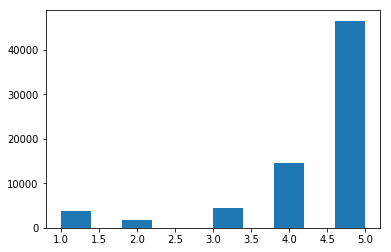

In [4]:
plt.hist(df['reviews.rating'])

Due to the distribution of the ratings, we will consider that a customer is pleased by the product if the rating is higher than 3. Thus we will consider that a customer doesn't make a good review when the rating is equal or lower to 3.

In [5]:
df['target'] = df['reviews.rating']<4

/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:778: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  a, weights = _ravel_and_check_weights(a, weights)


TypeError: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

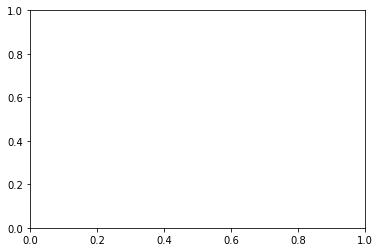

In [6]:
plt.hist(df['target'])

We can see that we have a lot of "happy" customer due to our target distribution

In [7]:
train_text, test_text, train_y, test_y = train_test_split(df['reviews.text'],df['target'],test_size = 0.2)

In [8]:
train_text.shape

(56835,)

### Preprocessing text for the (supervised) CBOW model

We will implement a simple classification model in Keras. Raw text requires (sometimes a lot of) preprocessing.

The following cells uses Keras to preprocess text:
- using a tokenizer. You may use different tokenizers (from scikit-learn, NLTK, custom Python function etc.). This converts the texts into sequences of indices representing the `20000` most frequent words
- sequences have different lengths, so we pad them (add 0s at the end until the sequence is of length `1000`)
- we convert the output classes as 1-hot encodings

In [9]:
MAX_NB_WORDS = 20000

# get the raw text data
texts_train = train_text.astype(str)
texts_test = test_text.astype(str)

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(texts_train)
sequences = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

/opt/conda/lib/python3.6/site-packages/keras_preprocessing/text.py:177: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 26057 unique tokens.


In [10]:
sequences[0]

[589,
 37,
 1,
 128,
 80,
 125,
 5,
 690,
 29,
 61,
 3,
 244,
 130,
 341,
 17,
 21,
 1,
 887,
 8,
 1286,
 919,
 58,
 527,
 200,
 130,
 273,
 41,
 1626,
 804,
 94,
 117,
 3,
 19,
 72,
 612,
 110,
 44,
 85,
 180,
 1082,
 108,
 29,
 319,
 112,
 68,
 402,
 88,
 489,
 2,
 44,
 211,
 30,
 6,
 18,
 767]

The tokenizer object stores a mapping (vocabulary) from word strings to token ids that can be inverted to reconstruct the original message (without formatting):

In [11]:
type(tokenizer.word_index), len(tokenizer.word_index)

(dict, 26057)

In [12]:
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())

In [13]:
" ".join([index_to_word[i] for i in sequences[0]])

"i'd like the old tide back it cleaned so well and left clothes smelling great but the addition of acti lift has changed everything clothes come out stiff rather than soft and with no pleasant scent just an off odor i'm so disappointed i've been trying other brands i just can't use this product anymore"


Let's have a closer look at the tokenized sequences:

In [14]:
seq_lens = [len(s) for s in sequences]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))

average length: 39.4
max length: 1034


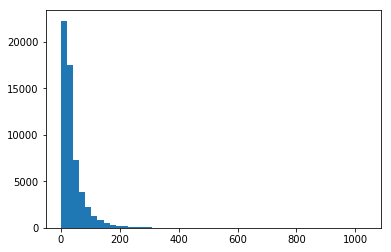

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(seq_lens, bins=50);


Let's zoom on the distribution of regular sized posts. The vast majority of the posts have less than 200 symbols:

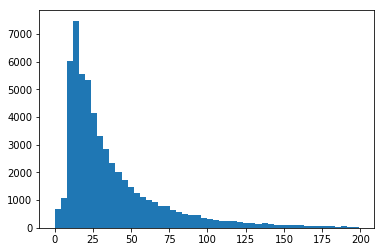

In [16]:
plt.hist([l for l in seq_lens if l < 200], bins=50);

In [17]:
MAX_SEQUENCE_LENGTH = 150

# pad sequences with 0s
x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x_train.shape)
print('Shape of data test tensor:', x_test.shape)

Shape of data tensor: (56835, 150)
Shape of data test tensor: (14209, 150)


In [18]:
y_train = train_y
y_test = test_y

y_train = to_categorical(np.asarray(y_train))
print('Shape of label tensor:', y_train.shape)

Shape of label tensor: (56835, 2)


## A simple supervised CBOW model in Keras

Vector space model is well known in information retrieval where each document is represented as a vector. The vector components represent weights or importance of each word in the document. The similarity between two documents is computed using the cosine similarity measure.

![](https://iksinc.files.wordpress.com/2015/04/screen-shot-2015-04-12-at-10-58-21-pm.png?w=768&h=740)

image & explanation taken from : https://iksinc.online/tag/continuous-bag-of-words-cbow/

In [19]:
from keras.layers import Dense, Input, Flatten
from keras.layers import GlobalAveragePooling1D, Embedding
from keras.models import Model

EMBEDDING_DIM = 50
N_CLASSES = 2

# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences = embedding_layer(sequence_input)

average = GlobalAveragePooling1D()(embedded_sequences)
predictions = Dense(N_CLASSES, activation='softmax')(average)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['acc'])

In [20]:
model.fit(x_train, y_train, validation_split=0.1,
          nb_epoch=10, batch_size=128)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 51151 samples, validate on 5684 samples
Epoch 1/10
51151/51151 [==============================] - 5s 94us/step - loss: 0.4002 - acc: 0.8615 - val_loss: 0.3598 - val_acc: 0.8628
Epoch 2/10
51151/51151 [==============================] - 3s 50us/step - loss: 0.3226 - acc: 0.8719 - val_loss: 0.3049 - val_acc: 0.8774
Epoch 3/10
51151/51151 [==============================] - 3s 49us/step - loss: 0.2700 - acc: 0.8899 - val_loss: 0.2696 - val_acc: 0.8892
Epoch 4/10
51151/51151 [==============================] - 3s 49us/step - loss: 0.2388 - acc: 0.9024 - val_loss: 0.2549 - val_acc: 0.9015
Epoch 5/10
51151/51151 [==============================] - 2s 49us/step - loss: 0.2202 - acc: 0.9121 - val_loss: 0.2440 - val_acc: 0.9039
Epoch 6/10
51151/51151 [==============================] - 3s 49us/step - loss: 0.2075 - acc: 0.9176 - val_loss: 0.2404 - val_acc: 0.9061
Epoch 7/10
51151/51151 [==============================] - 2s 49us/step - loss: 0.1972 - acc: 0.9232 - val_loss: 0.2360 - val_acc:

In [21]:
output_test = model.predict(x_test)
print("test auc:", roc_auc_score(y_test,output_test[:,1]))

test auc: 0.9111236825983193


## A complex model : LSTM

![](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)

image taken from : http://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [22]:
# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

x = LSTM(128, dropout=0.2, recurrent_dropout=0.2)(embedded_sequences)
predictions = Dense(2, activation='softmax')(x)


model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [23]:
model.fit(x_train, y_train, validation_split=0.1,
          nb_epoch=2, batch_size=128)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 51151 samples, validate on 5684 samples
Epoch 1/2
51151/51151 [==============================] - 149s 3ms/step - loss: 0.1908 - acc: 0.9292 - val_loss: 0.2550 - val_acc: 0.9134
Epoch 2/2
51151/51151 [==============================] - 149s 3ms/step - loss: 0.1689 - acc: 0.9383 - val_loss: 0.2338 - val_acc: 0.9136


In [24]:
output_test = model.predict(x_test)
print("test auc:", roc_auc_score(y_test,output_test[:,1]))

test auc: 0.914338779715014


## A more complex model : CNN - LSTM

In [25]:
# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

# 1D convolution with 64 output channels
x = Conv1D(64, 5)(embedded_sequences)
# MaxPool divides the length of the sequence by 5
x = MaxPooling1D(5)(x)
x = Dropout(0.2)(x)
x = Conv1D(64, 5)(x)
x = MaxPooling1D(5)(x)
# LSTM layer with a hidden size of 64
x = Dropout(0.2)(x)
x = LSTM(64)(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [26]:
model.fit(x_train, y_train, validation_split=0.1,
          nb_epoch=5, batch_size=128)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 51151 samples, validate on 5684 samples
Epoch 1/5
51151/51151 [==============================] - 15s 292us/step - loss: 0.1885 - acc: 0.9290 - val_loss: 0.2384 - val_acc: 0.9133
Epoch 2/5
51151/51151 [==============================] - 10s 187us/step - loss: 0.1633 - acc: 0.9389 - val_loss: 0.2365 - val_acc: 0.9147
Epoch 3/5
51151/51151 [==============================] - 10s 197us/step - loss: 0.1531 - acc: 0.9435 - val_loss: 0.2371 - val_acc: 0.9131
Epoch 4/5
51151/51151 [==============================] - 10s 197us/step - loss: 0.1408 - acc: 0.9485 - val_loss: 0.2499 - val_acc: 0.9164
Epoch 5/5
51151/51151 [==============================] - 10s 194us/step - loss: 0.1273 - acc: 0.9543 - val_loss: 0.2629 - val_acc: 0.9163


In [27]:
output_test = model.predict(x_test)
print("test auc:", roc_auc_score(y_test,output_test[:,1]))

test auc: 0.9046383311192198


The model seems to overfit. Indeed the train error is really low whereas the test error is really higher. It seems that we have a variance porblem. Adding regularization like drop-out may help to stabilize the performance

Edit : we have added drop-out. It is still not enough. We need to work on regularization technics to stabilize our performance.

Edit2 : With less epochs, we manage to reduce the variance.

### Visualize the outputs of our own Embeddings

We are going to use our precedent model for our embedding. Then we will pass our 100 first reviews in the embedding and plot them with the label.

In [28]:
from keras import backend as K
get_emb_layer_output = K.function([model.layers[0].input],
                                  [model.layers[2].input])
embedding_output = get_emb_layer_output([x_test[:3000]])[0]

In [29]:
emb_shape = embedding_output.shape
to_plot_embedding = embedding_output.reshape(emb_shape[0],emb_shape[1]*emb_shape[2])
y = y_test[:3000]

to visualize our results we will use tsne

In [30]:
sentence_emb_tsne = TSNE(perplexity=30).fit_transform(to_plot_embedding)

In [31]:
print(sentence_emb_tsne.shape)
print(y.shape)

(3000, 2)
(3000,)


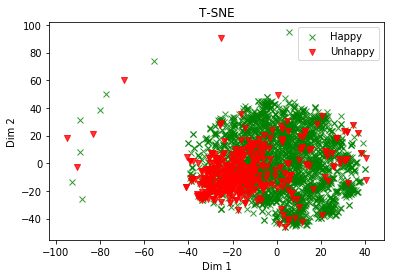

In [32]:
plt.figure()
plt.scatter(sentence_emb_tsne[np.where(y == 0), 0],
                   sentence_emb_tsne[np.where(y == 0), 1],
                   marker='x', color='g',
                   linewidth='1', alpha=0.8, label='Happy')
plt.scatter(sentence_emb_tsne[np.where(y == 1), 0],
                   sentence_emb_tsne[np.where(y == 1), 1],
                   marker='v', color='r',
                   linewidth='1', alpha=0.8, label='Unhappy')

plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.title('T-SNE')
plt.legend(loc='best')
plt.savefig('1.png')
plt.show()  

We can definitly see a trand in our representation between negative and postive sentences.